# Airline on-time performance 

When traveling by plane, you may encounter delays or cancellations. This assignment is to understand what causes flight delays. The data from the "Airline on time performance" dataset on Kaggle is used for analysis. This dataset is from the 2009 ASA Statistical and Graphical Data Expo and includes all commercial flight arrival and departure details of major airlines in the United States from October 1987 to April 2008. This is a huge dataset. I selected data from 2005 and analyzed the causes of flight delays through the following four aspects: Delay Patterns, Delay Factors, Cancellation Analysis and Problematic Routes.

I will use PyHive to connect Jupyter to Hive to import, query and analyze data.

In [1]:
from impala.dbapi import connect

conn=connect(
   host='192.168.121.128',
   port=10000,
   user='maria_dev',
   database='default',
   auth_mechanism='PLAIN')
cursor=conn.cursor()
cursor.execute('SHOW TABLES')
print(cursor.fetchall())

[('airline_2005',), ('airline_cleaned_2005',), ('har_features_sample',)]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Delay Patterns

Select columns year, month, dayofweek, deptime, arrtime, uniquecarrier and arrdelay from the data for Delay Patterns analysis. These columns are referred to as df1 table.

In [7]:
# Reading data from Hive
query1="""
SELECT year, month, dayofweek, deptime, arrtime, 
uniquecarrier, arrdelay FROM airline_2005
"""
df1=pd.read_sql(query1, conn)

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\3429962174.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1=pd.read_sql(query1, conn)


There are some "NA" non-standard missing values ​​in string format in the df1 table, so "NA" should be replaced with pandas' missing value object pd.NA. Then convert the deptime, arrtime, arrdelay and dayofweek fields from strings to numeric types.

In [8]:
# Convert NA values in the data into missing values
df1.replace('NA', pd.NA, inplace=True)
df1['deptime'] = pd.to_numeric(df1['deptime'], errors='coerce')
df1['arrtime'] = pd.to_numeric(df1['arrtime'], errors='coerce')
df1['arrdelay'] = pd.to_numeric(df1['arrdelay'], errors='coerce')
df1['dayofweek'] = pd.to_numeric(df1['dayofweek'], errors='coerce')

- ### Average Delay Per Day

First, divide the time into 4 periods. The morning take-off period is from 5:00 to 11:59, the afternoon period is from 12:00 to 19:59, the evening period is from 20:00 to 23:59 (including 23:59), and the rest of the time is the midnight period.

In [11]:
# Times of day have the lowest average delays
def time(deptime):
    if pd.isna(deptime):
        return pd.NA
    if not isinstance(deptime, (int, float)) or not (0 <= deptime <= 2359):
        return pd.NA
    elif 500 <= deptime < 1200:
        return 'morning'
    elif 1200 <= deptime < 2000:
        return 'afternoon'
    elif 2000 <= deptime <= 2359:
        return 'evening'
    else:
        return 'midnight'

The divided time periods are added as a new column, and the number of flights in each time period is printed. The average delay of each time period is calculated and printed.

In [13]:
df1['timeofday']=df1['deptime'].apply(time)
print("Flight quantity distribution by time period:")
print(df1['timeofday'].value_counts(dropna=False))
delaytime=df1.groupby('timeofday')['arrdelay'].mean().sort_values()
print("\nAverage delay by time of day:")
print(delaytime)

Flight quantity distribution by time period:
timeofday
afternoon    3445825
morning      2781773
evening       744258
<NA>          135806
midnight       32934
Name: count, dtype: int64

Average delay by time of day:
timeofday
morning       0.429412
afternoon     8.794240
evening      22.521892
midnight     56.189318
Name: arrdelay, dtype: float64


It can be seen that the number of flights in the afternoon period is the largest, and the number of flights in the midnight period is the smallest. From the calculated average delay of each time period, it can be seen that the morning delay is the smallest, and the midnight delay is the largest, up to 56.2.

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\3046471982.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delaytime.index, y=delaytime.values, palette="viridis", edgecolor="black")


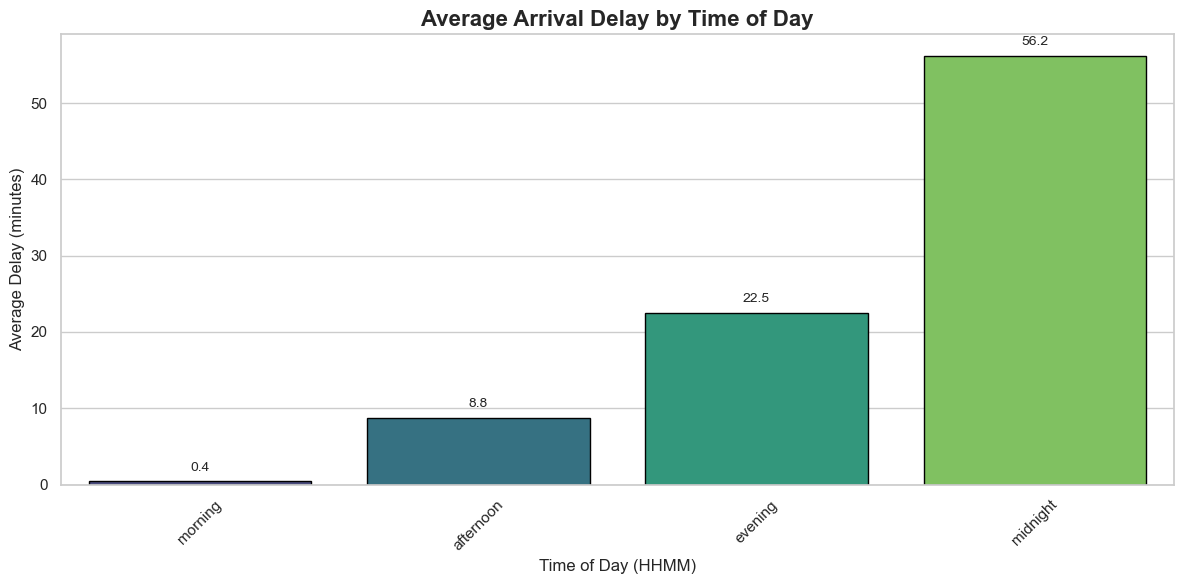

In [15]:
# bar chart of average arrival delay by time of day
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=delaytime.index, y=delaytime.values, palette="viridis", edgecolor="black")
for i, v in enumerate(delaytime.values):
    plt.text(i, v + 1, f"{v:.1f}", ha='center', va='bottom', fontsize=10)

plt.title('Average Arrival Delay by Time of Day', fontsize=16, fontweight='bold')
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.xlabel('Time of Day (HHMM)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

By visualizing the data, we can see that the average delays in the morning and afternoon time periods are relatively small, with an average delay of 0.4 in the morning, 8.8 in the afternoon, and 56.2 in the midnight. This means that there are basically no delays in morning flights, but many midnight flights are delayed. It is speculated that the high delays may be due to the fact that there were delayed flights before, and if there were delays in a certain period of time, all subsequent flights would be delayed; it may also be that there are very few flights at midnight, and if some flights are seriously delayed, the overall average will be significantly raised.

- ### Days Of Week

Convert the numeric weekday to English weekday and create a new column in df1 called dayname using week_map.

In [17]:
# days of the week show better on-time performance
# Set the day of the week corresponding to the number
week_map={
    1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 
    5:'Fri', 6:'Sat', 7:'Sun'
}
df1['dayname']=df1['dayofweek'].map(week_map)

Calculate the average delay from Monday to Sunday and print it out.Show that Saturday has the lowest average delay and Thursday has the highest average delay.

In [19]:
delayday=df1.groupby('dayname')['arrdelay'].mean().sort_values()
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
delayday = delayday.reindex(day_labels)
print("Average delay by day of week:")
print(delayday)

Average delay by day of week:
dayname
Mon    7.860761
Tue    5.367869
Wed    7.556946
Thu    9.672332
Fri    9.514468
Sat    3.301072
Sun    6.454012
Name: arrdelay, dtype: float64


C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\546399151.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_labels, y=delayday.values, palette="coolwarm", edgecolor='black')


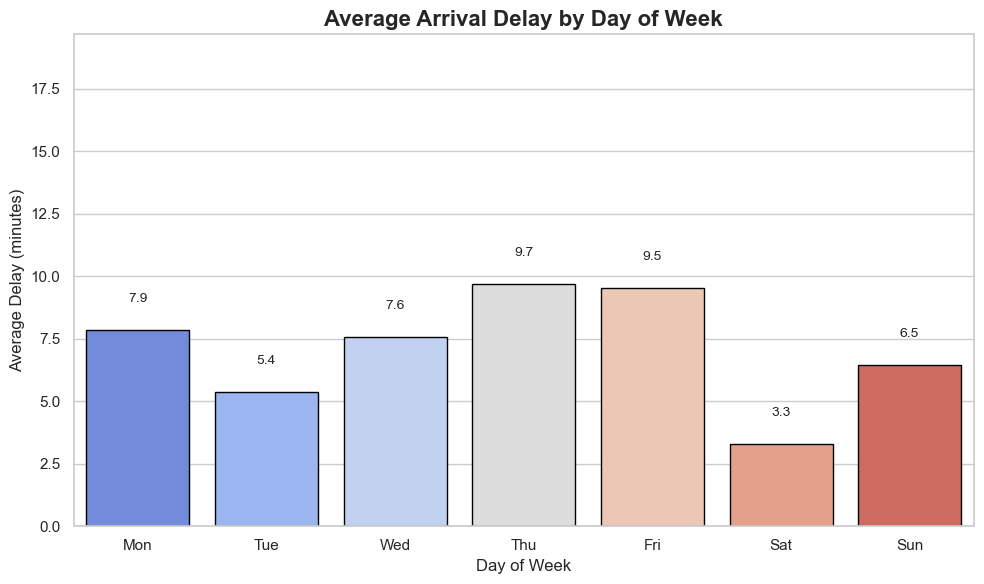

In [21]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=day_labels, y=delayday.values, palette="coolwarm", edgecolor='black')

for i, v in enumerate(delayday.values):
    plt.text(i, v + 1, f"{v:.1f}", ha='center', va='bottom', fontsize=10)

plt.title('Average Arrival Delay by Day of Week', fontsize=16, fontweight='bold')
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.ylim(0, max(delayday.values) + 10)
plt.tight_layout()
plt.show()

Visualizing it, we can see from the chart that Sat performs best during the week. We speculate that the reason for its good performance may be that business flights are concentrated from Monday to Friday, and airlines will schedule fewer flights on Saturdays than from Monday to Friday, so the pressure of control will be reduced and the average delay will be reduced. Thursday performs the worst during the week, with an average delay of 9.7. We speculate that the reason for the high average delay is that Thursday is a backlog day for flight rolling delays. If there are many delays on Monday and Tuesday, "rolling delays" are likely to break out on Wednesday and Thursday. The scheduling on Thursday is already very tight, and airlines lack buffer space, so delays are more likely to break out. Starting from Thursday night, there are weekend tourist flights, the route load increases, the flight density increases, and the system is prone to jams.

- ### Month

The average delay for each month was calculated. The results show that the average delay in July was the highest and the average delay in April was the lowest.

In [23]:
# months or seasons are flights most likely to be on time
delaymonth=df1.groupby('month')['arrdelay'].mean().sort_values()
print("Average delay by month:")
print(delaymonth)

Average delay by month:
month
4      2.594827
9      2.645287
5      3.039096
10     4.585050
11     5.188487
2      6.184216
3      7.621901
8      8.992975
6      9.813724
1     10.040142
12    11.195766
7     13.853831
Name: arrdelay, dtype: float64


C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\1278621515.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_labels, y=delaymonth.values, palette='Spectral', edgecolor='black')


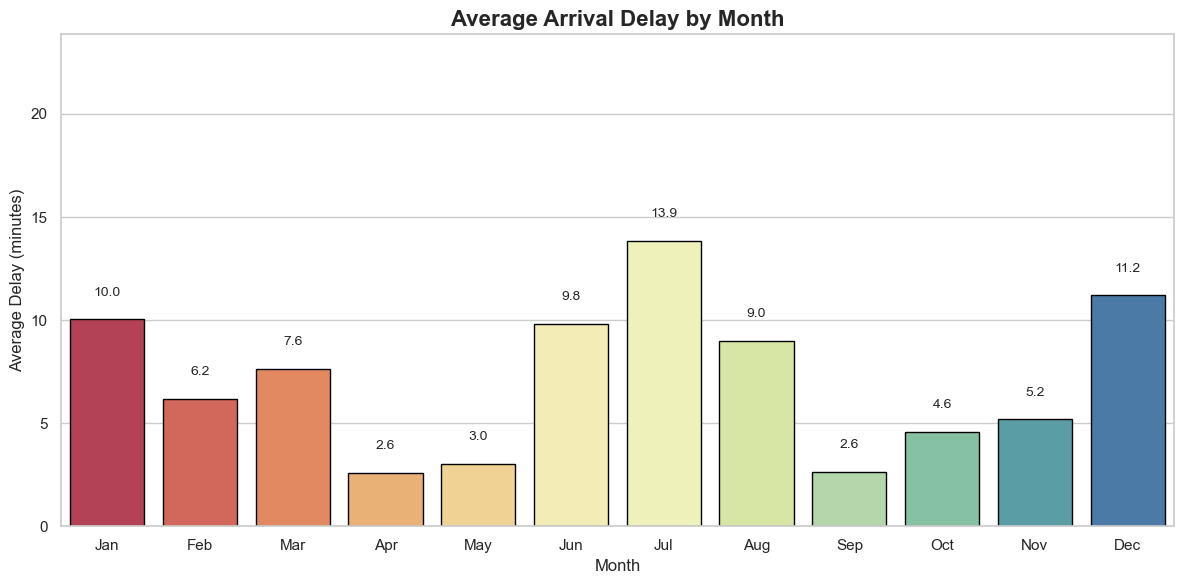

In [25]:
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
delaymonth = delaymonth.reindex(range(1, 13)) 
plt.figure(figsize=(12, 6))
sns.barplot(x=month_labels, y=delaymonth.values, palette='Spectral', edgecolor='black')
for i, v in enumerate(delaymonth.values):
    plt.text(i, v + 1, f"{v:.1f}", ha='center', va='bottom', fontsize=10)

plt.title('Average Arrival Delay by Month', fontsize=16, fontweight='bold')
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.ylim(0, max(delaymonth.values) + 10)
plt.tight_layout()
plt.show()

Visualizing it, we can see from the chart that the average delays are the lowest in April and September, and the highest in July. We guess that July is the month with the highest frequency of thunderstorms in the United States, and it is also the holiday season. Many people choose to travel during the holidays, and the increase in the number of flights will lead to an increase in the average delay. The weather in the United States is relatively stable in April and September, and the number of flights is reduced as the holidays are over. Therefore, the on-time performance of flights in April and September is good.

- ### Seasons

The twelve months are divided into four seasons: spring, summer, autumn and winter. March, April and May are spring, June, July and August are summer, September, October and November are autumn, and December, January and February are winter.

In [27]:
# Divide the seasons
def divide_seasons(month):
    if month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    elif month in [9,10,11]:
        return 'Fall'
    else:
        return 'Winter'
    
df1['seasons']=df1['month'].apply(divide_seasons)

In [29]:
# Seasonal average delay
delayseason=df1.groupby('seasons')['arrdelay'].mean().sort_values()
print("Average delay by season:")
print(delayseason)

Average delay by season:
seasons
Fall       4.143332
Spring     4.437985
Winter     9.189482
Summer    10.891552
Name: arrdelay, dtype: float64


The average delays for each season are calculated. The results show that the average delays are lowest in autumn and highest in summer.

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\359508462.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delayseason.index, y=delayseason.values, palette='pastel', edgecolor='black')


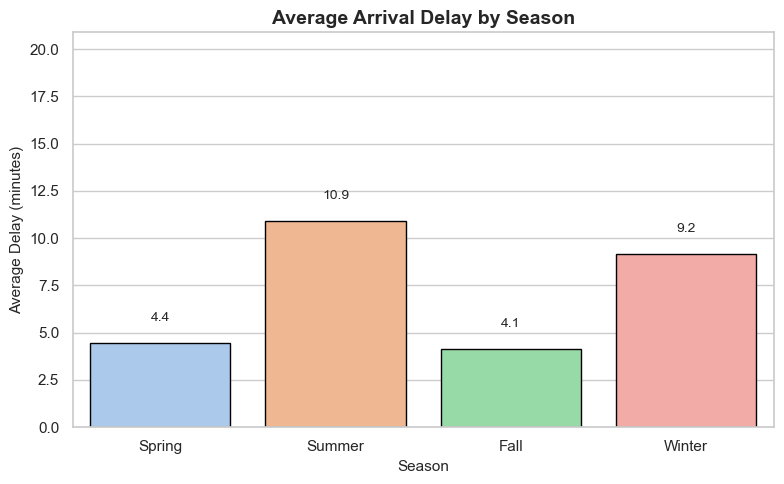

In [31]:
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
delayseason = delayseason.reindex(season_order)

plt.figure(figsize=(8, 5))
sns.barplot(x=delayseason.index, y=delayseason.values, palette='pastel', edgecolor='black')
for i, v in enumerate(delayseason.values):
    plt.text(i, v + 1, f"{v:.1f}", ha='center', va='bottom', fontsize=10)

plt.title('Average Arrival Delay by Season', fontsize=14, fontweight='bold')
plt.ylabel('Average Delay (minutes)', fontsize=11)
plt.xlabel('Season', fontsize=11)
plt.ylim(0, max(delayseason.values) + 10)
plt.tight_layout()
plt.show()

Visualizing it, we can see from the chart that the average delay in autumn and spring is low, 4.1 in autumn and 4.4 in spring, while the average delay in summer is as high as 10.9. It is speculated that this is because the weather conditions in spring and autumn are stable, there are no major or minor holidays, and it is in the middle of the semester, so the flight density is low, so the average delay is low and the flight punctuality performance is good.

From the analysis of Delay Patterns, the results show that flight delays are obviously closely related to time factors. First, from the perspective of different time periods, the average delay time in the early morning period is the highest (up to 56.2 minutes), while the delay in the morning period is the smallest (only 0.4 minutes), indicating that flights are more likely to take off and land on time in the early morning. Secondly, from the perspective of weekly distribution, the delay time on Thursday and Friday is relatively high, which may be due to system congestion caused by previous flight backlogs and weekend travel peaks; while Saturday has the smallest delay, which is related to the relatively small number of flights and reduced airspace pressure. In terms of the monthly dimension, the delay in July is the most serious (13.9 minutes), which may be related to the holiday peak and frequent thunderstorms; while the delays in April and September are the smallest, reflecting the stable climate and moderate flight density. Finally, seasonal analysis shows that delays are highest in summer and lowest in autumn, further verifying that there is a significant time periodicity in flight delays.

## 2. Delay Factors

Select the factors causing delay from the data set, namely carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay, and convert them into DataFrame.

In [33]:
# Select data
query2="""
SELECT
  SUM(CAST(CASE WHEN carrierdelay = 'NA' THEN NULL ELSE carrierdelay END AS INT)) AS carrierdelay,
  SUM(CAST(CASE WHEN weatherdelay = 'NA' THEN NULL ELSE weatherdelay END AS INT)) AS weatherdelay,
  SUM(CAST(CASE WHEN nasdelay = 'NA' THEN NULL ELSE nasdelay END AS INT)) AS nasdelay,
  SUM(CAST(CASE WHEN securitydelay = 'NA' THEN NULL ELSE securitydelay END AS INT)) AS securitydelay,
  SUM(CAST(CASE WHEN lateaircraftdelay = 'NA' THEN NULL ELSE lateaircraftdelay END AS INT)) AS lateaircraftdelay
FROM airline_2005
WHERE year = 2005
  AND cancelled = 0
"""
df2=pd.read_sql(query2, conn)

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\87311464.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2=pd.read_sql(query2, conn)


The cumulative delay minutes of all flights of this type are calculated, and a new column "Percentage" is created to indicate the percentage of this delay type in the total delay time.

In [8]:
delayfactors = {
    "Carrier Delay": df2['carrierdelay'][0],
    "Weather Delay": df2['weatherdelay'][0],
    "NAS Delay": df2['nasdelay'][0],
    "Security Delay": df2['securitydelay'][0],
    "Late Aircraft Delay": df2['lateaircraftdelay'][0]
}

delayfac = pd.DataFrame(list(delayfactors.items()), columns=["Delay Type", "Total Delay (min)"])
delayfac["Percentage"] = delayfac["Total Delay (min)"] / delayfac["Total Delay (min)"].sum() * 100

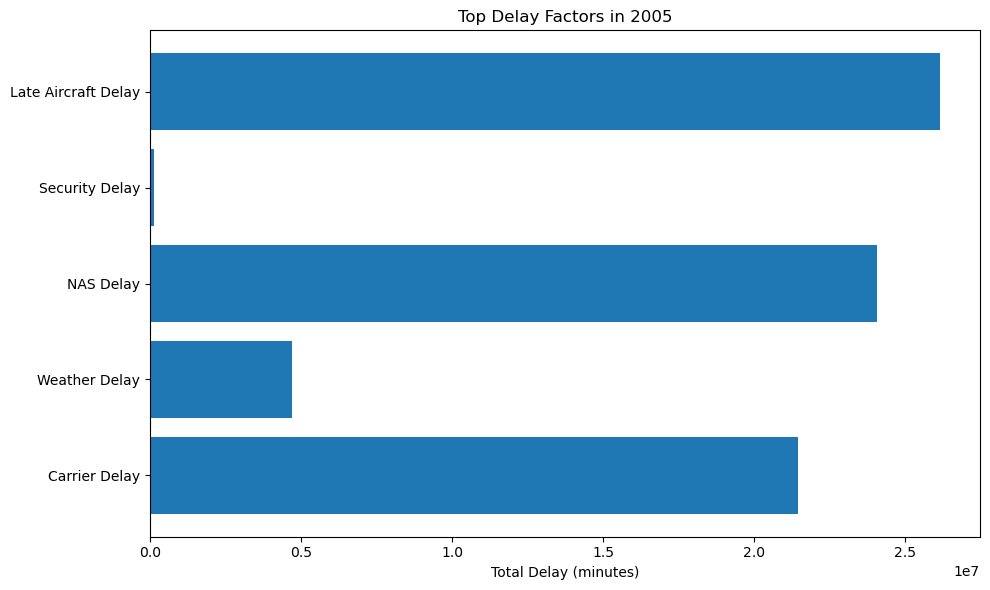

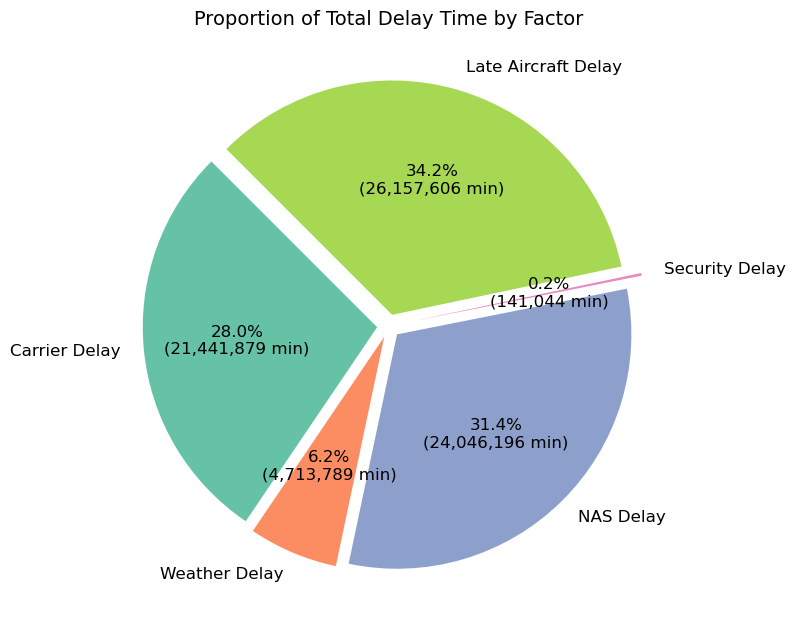

In [11]:
#bar chart 
plt.figure(figsize=(10,6))
plt.barh(delayfac["Delay Type"], delayfac["Total Delay (min)"])
plt.xlabel("Total Delay (minutes)")
plt.title("Top Delay Factors in 2005")
plt.tight_layout()
plt.show()
#pie chart 
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
explode = [0.05, 0.05, 0.05, 0.1, 0.05]
plt.figure(figsize=(8, 8))
plt.pie(
    delayfac["Percentage"],
    labels=delayfac["Delay Type"],
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100 * delayfac["Total Delay (min)"].sum()):,} min)',
    startangle=135,
    colors=colors,
    explode=explode,
    shadow=False,
    textprops={'fontsize': 12}
)
plt.title("Proportion of Total Delay Time by Factor", fontsize=14)
plt.tight_layout()
plt.show()

From these two charts, we can see that the number of delay minutes and proportion of lateaircraft,nas,carrier are relatively high, while the number of delay minutes and proportion of security are the smallest.Aircraft delays were the main cause, accounting for more than 34% of the total delay time; NAS-related delays were close behind, accounting for 31%; and airline-level issues, such as crew/aircraft scheduling, accounted for nearly 28%. Weather accounted for only 6.4% of delays, while the impact of safety-related delays was negligible, less than 1%.
The three major causes together accounted for more than 93% of the total impact of delays, highlighting the systemic nature of delays caused by operational and airspace factors.

From the above analysis, it can be seen that the main reasons for flight delays in 2005 can be attributed to airline factors, NAS problems, aircraft arrival delays and weather effects. Among them, Carrier Delay and NAS delays account for a large proportion and are the most common types of delays. Some airports and routes are frequently delayed, especially high-density routes or airports located at transportation hubs, which are more susceptible to poor scheduling and flight chain reactions. In addition, some airlines (such as FL, AS) show a higher average delay time, indicating that the delay problem also has a certain degree of airline dependence. Overall, flight delays are the result of the superposition of multiple factors, with obvious structurality and attributability, providing a data basis for subsequent optimization of scheduling and resource allocation.

## 3. Cancellation Analysis

Four cancellation reasons, Airline, Weather, NAS, and Security, are selected from the dataset.

In [113]:
# Query cancellation reason distribution
query3 = """
SELECT 
  reason,
  COUNT(*) AS cancel_count
FROM (
  SELECT 
    CASE cancellationcode
      WHEN 'A' THEN 'Airline'
      WHEN 'B' THEN 'Weather'
      WHEN 'C' THEN 'NAS'
      WHEN 'D' THEN 'Security'
    END AS reason
  FROM airline_2005
  WHERE year = 2005 
    AND cancelled = 1 
    AND cancellationcode IS NOT NULL 
    AND cancellationcode != 'NA'
) AS sub
GROUP BY reason
"""
df_cancel = pd.read_sql(query3, conn)

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\4038569268.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cancel = pd.read_sql(query3, conn)


In [114]:
df_cancel["Percentage"] = df_cancel["cancel_count"] / df_cancel["cancel_count"].sum() * 100
print(df_cancel)

     reason  cancel_count  Percentage
0   Airline         59350   44.380468
1       NAS         23084   17.261647
2  Security            92    0.068795
3   Weather         51204   38.289090


Count the number of flights that were actually canceled for these four reasons, and then calculate the percentage of cancellations and print them out. The results show that Airline and Weather are the main reasons for cancellations. Airline canceled the most flights, 59,350, accounting for 44.4%, and Security canceled the least flights, 92, accounting for 0.1%.

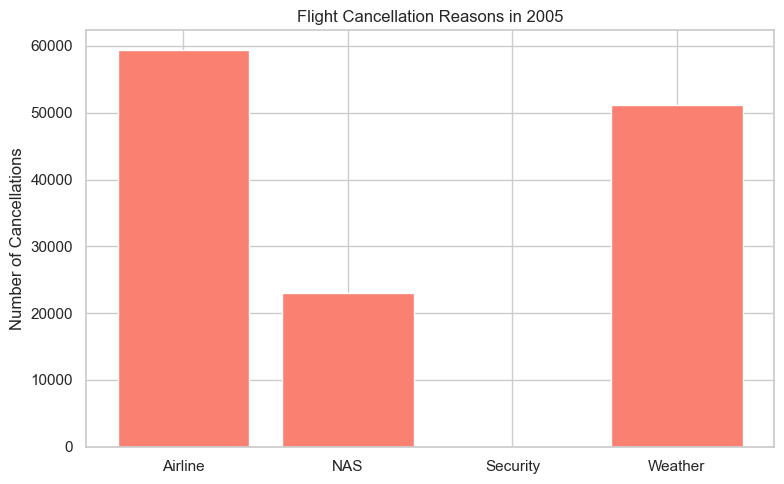

In [37]:
plt.figure(figsize=(8, 5))
plt.bar(df_cancel["reason"], df_cancel["cancel_count"], color="salmon")
plt.title("Flight Cancellation Reasons in 2005")
plt.ylabel("Number of Cancellations")
plt.tight_layout()
plt.show()

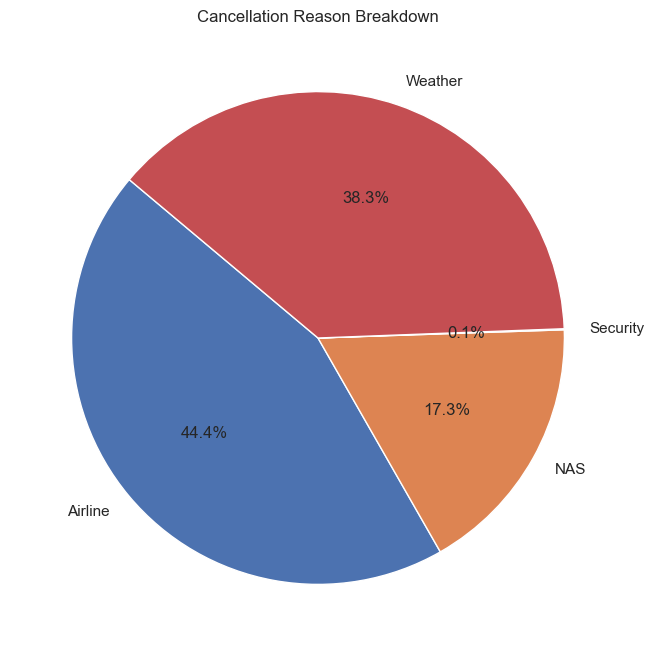

In [39]:
plt.figure(figsize=(8, 8))
plt.pie(df_cancel["Percentage"], labels=df_cancel["reason"], autopct="%1.1f%%", startangle=140)
plt.title("Cancellation Reason Breakdown")
plt.show()

Visualizing the number of flight cancellations and the cancellation ratio, we can get a bar chart and a pie chart. From these two charts, we can clearly see that Airline and Weather are the main reasons for cancellations, and NAS is second only to Airline and Weather. It is speculated that the high cancellation rate may be caused by the decision-making power of flights to control costs. When the operation is at its peak or resources are tight and cannot be allocated, the airline may cancel the flight. Weather factors are force majeure. Thunderstorms in summer, frost in winter, runway closures, or low visibility, etc., can only cancel flights for safety reasons.

In [41]:
# Cancellations by airline
query3_1 = """
SELECT uniquecarrier, COUNT(*) AS cancel_count
FROM airline_2005
WHERE year = 2005 AND cancelled = 1
GROUP BY uniquecarrier
ORDER BY cancel_count DESC
"""

df_carrier = pd.read_sql(query3_1, conn)
print(df_carrier)

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\671806627.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_carrier = pd.read_sql(query3_1, conn)


   uniquecarrier  cancel_count
0             DL         17731
1             MQ         16746
2             EV         13900
3             OH         11370
4             AA          9752
5             OO          9639
6             XE          9353
7             WN          8759
8             US          8426
9             NW          6937
10            UA          6296
11            DH          2877
12            CO          2739
13            AS          2630
14            HP          2487
15            FL          2448
16            B6           888
17            TZ           508
18            F9           175
19            HA            69


Select the airline code, count the number of cancelled flights for each airline and convert the counted data into a DataFrame.The results show that DL Airlines has the highest number of cancellations, reaching 17,731, while HA Airlines has the lowest number of cancellations, at 69.

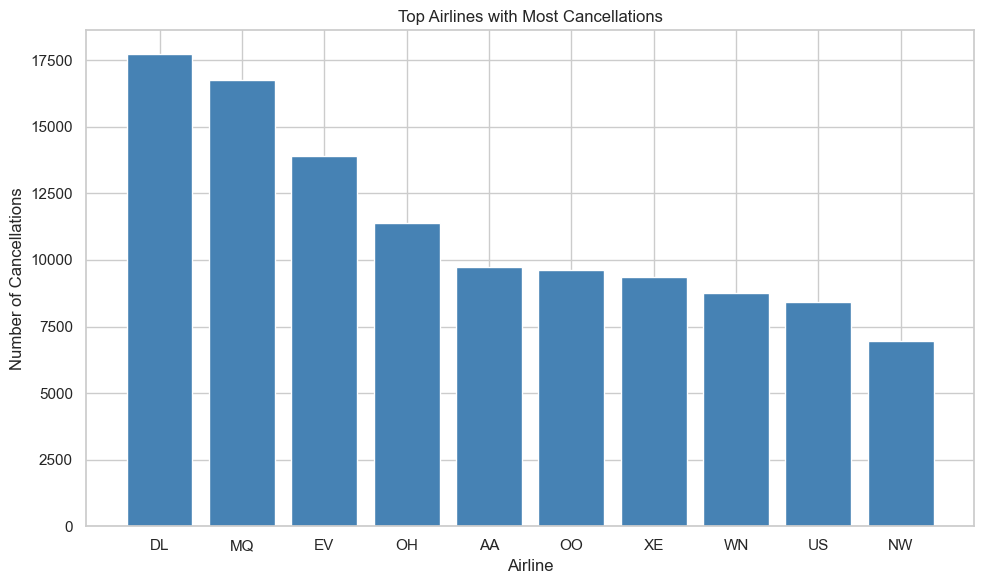

In [47]:
plt.figure(figsize=(10,6))
plt.bar(df_carrier.head(10)["uniquecarrier"], df_carrier.head(10)["cancel_count"], color='steelblue')
plt.ylabel("Number of Cancellations")
plt.xlabel("Airline")
plt.title("Top Airlines with Most Cancellations")
plt.tight_layout()
plt.show()

Visualize the cancellation numbers of the top ten airlines. From the chart, it can be seen that DL has the largest number of cancelled flights. Right behind it are MQ and EV. The cancellation numbers of other companies are relatively small, and the company with the fewest cancellations in this chart is NW.

In [49]:
# Cancellation rate analysis chart
query3_2 = """
SELECT 
  uniquecarrier,
  COUNT(*) AS total_flights,
  SUM(CAST(cancelled AS INT)) AS total_cancels,
  (SUM(CAST(cancelled AS INT)) * 100.0 / COUNT(*)) AS cancel_rate
FROM airline_2005
WHERE year = 2005
GROUP BY uniquecarrier
HAVING COUNT(*) > 50
ORDER BY cancel_rate DESC
LIMIT 10
"""

df_cancel_rate = pd.read_sql(query3_2, conn)

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\1169541368.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cancel_rate = pd.read_sql(query3_2, conn)


Select the airline to which it belongs, count the total number of flights of the airline in 2005, calculate the number of cancelled flights, calculate the cancellation rate, and select the top 10 flights in descending order of cancellation rate.

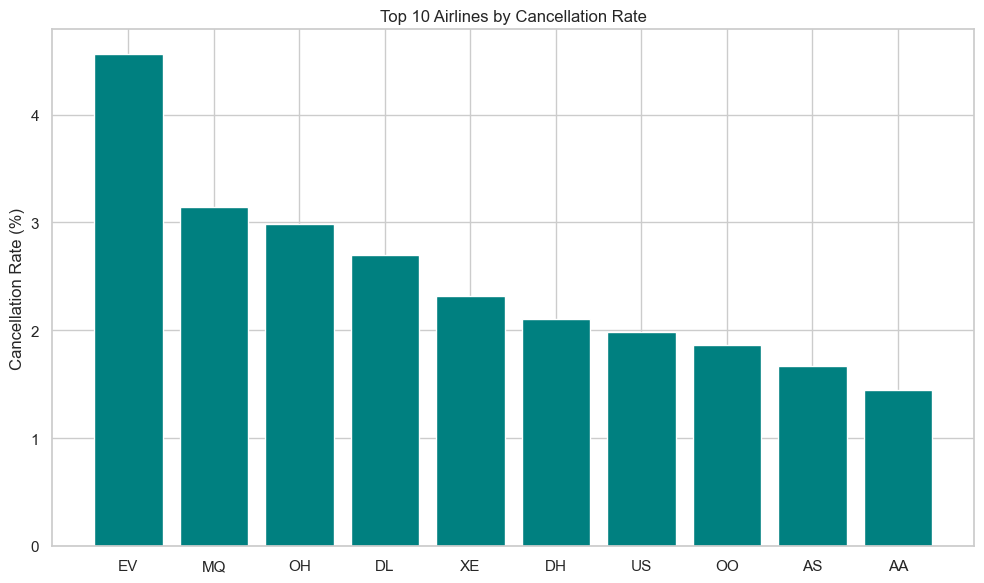

In [51]:
# Visualize cancellation rates
plt.figure(figsize=(10,6))
plt.bar(df_cancel_rate['uniquecarrier'], df_cancel_rate['cancel_rate'], color='teal')
plt.ylabel("Cancellation Rate (%)")
plt.title("Top 10 Airlines by Cancellation Rate")
plt.tight_layout()
plt.show()

The chart is generated, and it can be seen from the chart that EV has the highest cancellation rate, exceeding 4%. Then MQ, OH, DL and other airports decrease in a row. The airport with the lowest cancellation rate in the chart is AA, which is about 1.5%.

In [53]:
query3_3 = """
SELECT 
  origin,
  COUNT(*) AS total_flights,
  SUM(CAST(cancelled AS INT)) AS total_cancels,
  (SUM(CAST(cancelled AS INT)) * 100.0 / COUNT(*)) AS cancel_rate
FROM airline_2005
WHERE year = 2005
GROUP BY origin
HAVING COUNT(*) > 100
ORDER BY cancel_rate DESC
LIMIT 20
"""

df_airport = pd.read_sql(query3_3, conn)

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\3557605041.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_airport = pd.read_sql(query3_3, conn)


Select the departure airports of the flights, count the number of flight cancellations at each airport, and calculate the percentage of cancellations. Select the top 20 airports with the highest cancellations.

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\1355272453.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_airport, x='origin', y='cancel_rate', palette='viridis')


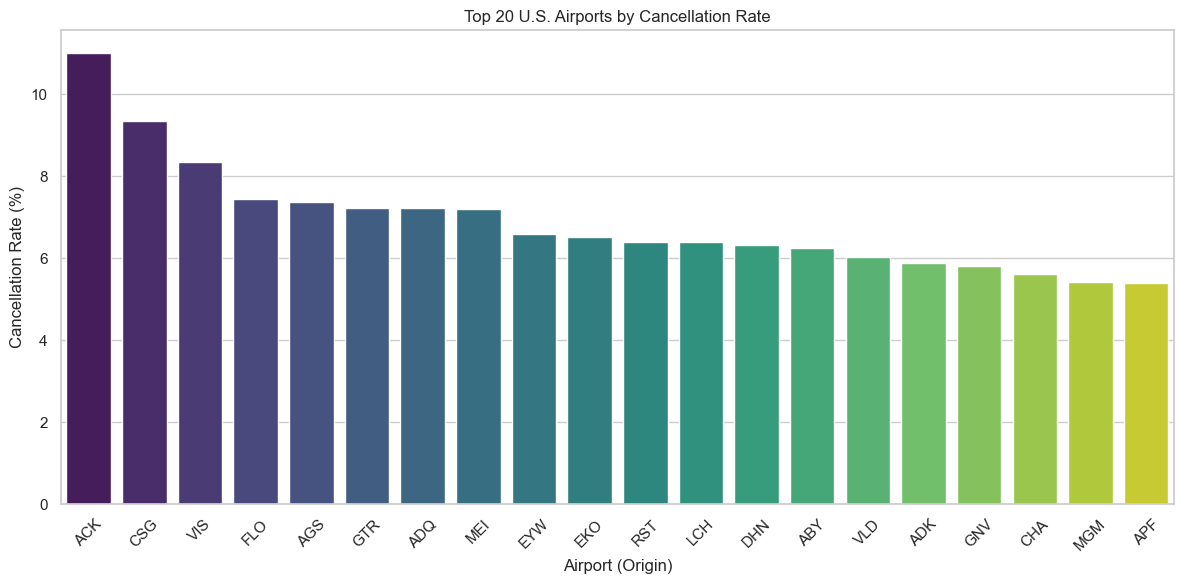

In [55]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_airport, x='origin', y='cancel_rate', palette='viridis')

plt.title("Top 20 U.S. Airports by Cancellation Rate")
plt.xlabel("Airport (Origin)")
plt.ylabel("Cancellation Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Visualizing it, we can see from the chart that ACK airport has the highest cancellation rate, followed by CSG airport, and APF airport has the lowest cancellation rate among the top 20 airports.

In [57]:
query_month_cancel = """
SELECT 
  month,
  COUNT(*) AS total_flights,
  SUM(CAST(cancelled AS INT)) AS total_cancels,
  (SUM(CAST(cancelled AS INT)) * 100.0 / COUNT(*)) AS cancel_rate
FROM airline_2005
WHERE year = 2005
GROUP BY month
ORDER BY month
"""
df_cancel_month = pd.read_sql(query_month_cancel, conn)

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\4045890532.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cancel_month = pd.read_sql(query_month_cancel, conn)


Select the data and group them by month, count the cancellations for each month and arrange the results in ascending order by month.

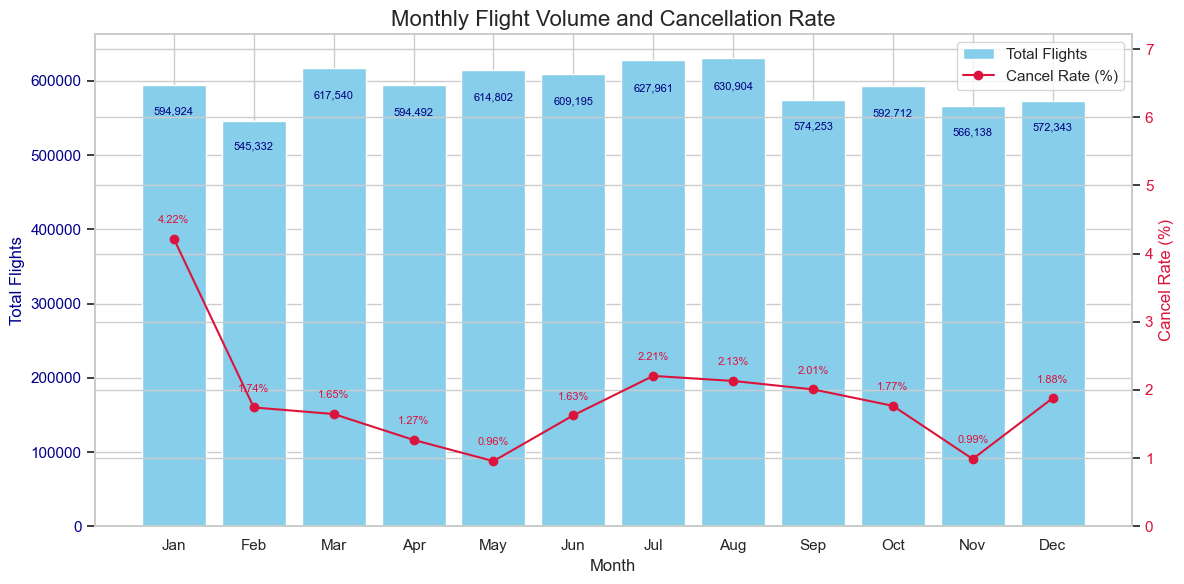

In [111]:
month_map = {
    1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
    7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
}
df_cancel_month['month_name'] = df_cancel_month['month'].map(month_map)
df_cancel_month = df_cancel_month.sort_values('month')

fig, ax1 = plt.subplots(figsize=(12, 6))

bars = ax1.bar(df_cancel_month['month_name'], df_cancel_month['total_flights'], color='skyblue', label='Total Flights')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Flights', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

max_flights = df_cancel_month['total_flights'].max()

for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height * 0.95,  
        f'{int(height):,}',
        ha='center',
        va='top',
        fontsize=8,
        color='navy'
    )

ax2 = ax1.twinx()
ax2.plot(df_cancel_month['month_name'], df_cancel_month['cancel_rate'], color='crimson', marker='o', label='Cancel Rate (%)')
ax2.set_ylabel('Cancel Rate (%)', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')

max_rate = df_cancel_month['cancel_rate'].max()
ax2.set_ylim(0, max_rate + 3) 

for i, rate in enumerate(df_cancel_month['cancel_rate']):
    ax2.text(
        i,
        rate + 0.2,
        f"{rate:.2f}%",
        ha='center',
        va='bottom',
        fontsize=8,
        color='crimson'
    )

plt.title('Monthly Flight Volume and Cancellation Rate', fontsize=16)
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()

The chart clearly shows the seasonal variation in flight volume and cancellation rate throughout 2005. Although flight volume peaks in the summer, the highest cancellation rate occurs in January at 4.22%, which may be due to winter weather conditions. The lowest cancellation rates occur in May and November, indicating that these two periods are relatively stable. This trend shows that there is a significant inverse relationship between flight reliability and seasonal extremes related to weather.

In [87]:
query_cancel_season = """
SELECT 
  CASE 
    WHEN month IN (3, 4, 5) THEN 'Spring'
    WHEN month IN (6, 7, 8) THEN 'Summer'
    WHEN month IN (9, 10, 11) THEN 'Fall'
    ELSE 'Winter'
  END AS season,
  COUNT(*) AS total_flights,
  SUM(CAST(cancelled AS INT)) AS total_cancels,
  (SUM(CAST(cancelled AS INT)) * 100.0 / COUNT(*)) AS cancel_rate
FROM airline_2005
WHERE year = 2005
GROUP BY 
  CASE 
    WHEN month IN (3, 4, 5) THEN 'Spring'
    WHEN month IN (6, 7, 8) THEN 'Summer'
    WHEN month IN (9, 10, 11) THEN 'Fall'
    ELSE 'Winter'
  END
ORDER BY cancel_rate DESC
"""
df_cancel_season = pd.read_sql(query_cancel_season, conn)

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\711495089.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cancel_season = pd.read_sql(query_cancel_season, conn)


Select data and group them by season, count the number of flights and cancellation rate in each season, and sort them from high to low according to cancellation rate to facilitate identification of the season with the highest cancellation rate.

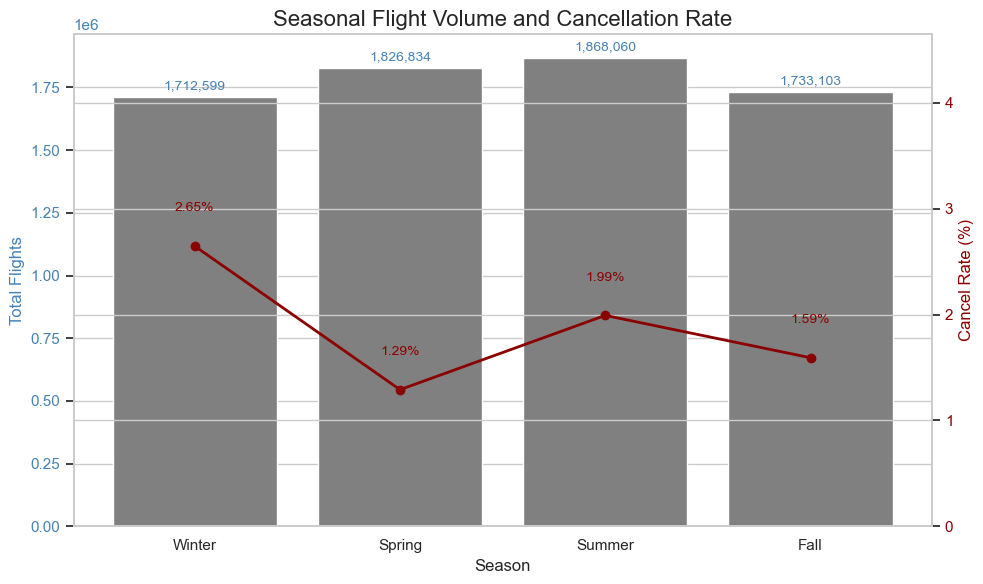

In [103]:
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
df_cancel_season['season'] = pd.Categorical(df_cancel_season['season'], categories=season_order, ordered=True)
df_cancel_season = df_cancel_season.sort_values('season')

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=df_cancel_season,
    x='season',
    y='total_flights',
    ax=ax1,
    color='gray'
)
ax1.set_ylabel('Total Flights', color='steelblue')
ax1.set_xlabel('Season')
ax1.tick_params(axis='y', labelcolor='steelblue')
for bar in bars.patches:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(df_cancel_season['total_flights']) * 0.01, 
        f'{int(height):,}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='steelblue'
    )

ax2 = ax1.twinx()
ax2.plot(
    df_cancel_season['season'],
    df_cancel_season['cancel_rate'],
    color='darkred',
    marker='o',
    linewidth=2
)
ax2.set_ylabel('Cancel Rate (%)', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

max_rate = df_cancel_season['cancel_rate'].max()
ax2.set_ylim(0, max_rate + 2)

for i, rate in enumerate(df_cancel_season['cancel_rate']):
    ax2.text(i, rate + 0.3, f"{rate:.2f}%", 
             ha='center', 
             va='bottom',
             fontsize=10,
             color='darkred')

plt.title('Seasonal Flight Volume and Cancellation Rate', fontsize=16)

plt.tight_layout()
plt.show()

The chart clearly shows the seasonal changes in the number of flights and the cancellation rate. The cancellation rate is highest in winter at 2.65%, although the number of flights is the lowest, which is presumably related to bad weather. In contrast, the cancellation rate is lowest in spring at 1.29%, which is the most stable flight season of the year. Summer flights are the most dense, but the cancellation rate rises slightly, which may be related to air traffic pressure or thunderstorms.

From the above analysis, we can see that flight cancellation behavior is highly correlated with specific time periods in 2005, especially in winter and the first quarter, where the cancellation rate is significantly higher, which may be affected by seasonal weather factors such as blizzards and freezing. In addition, some airports and routes, such as flights involving EWR, have repeatedly been canceled and delayed, indicating that these hubs have operational bottlenecks or traffic pressure. At the same time, from the perspective of airlines, the average delay and cancellation rates of airlines such as FL and AS are both high, reflecting their differences in flight reliability. Therefore, flight cancellations are not random phenomena, but have obvious time, regional and airline-dependent characteristics, which can provide targeted optimization suggestions to airlines and management departments.

## 4. Problematic Routes

Create a new table and filter out irregular missing values ​​in the data to ensure that field values are not incorrectly parsed as strings, NULL or other non-numeric characters.

In [117]:
#Create a temporary form
query_clean = """
CREATE TABLE IF NOT EXISTS airline_cleaned_2005 AS
SELECT *
FROM airline_2005
WHERE year = 2005
  AND arrdelay RLIKE '^-?[0-9]+$'
  AND depdelay RLIKE '^-?[0-9]+$'
  AND cancelled RLIKE '^[01]$'
  AND distance RLIKE '^[0-9.]+$'
  AND CRSDepTime RLIKE '^[0-9]+$'
  AND CRSArrTime RLIKE '^[0-9]+$'
"""
cur = conn.cursor()
cur.execute(query_clean)

The routes with the most serious delays from the origin to the destination were selected from the cleaned data, and the top 20 routes with more than 50 flights and the longest average time to heavy smoke were selected.

In [135]:
#Problem route analysis（origin → dest）
query_routes = """
SELECT origin, dest,
       COUNT(*) AS flight_count,
       AVG(CAST(arrdelay AS INT)) AS avg_arr_delay
FROM airline_cleaned_2005
GROUP BY origin, dest
HAVING flight_count > 50
ORDER BY avg_arr_delay DESC
LIMIT 20
"""

df_routes = pd.read_sql(query_routes, conn)
print(df_routes)

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\3682256370.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_routes = pd.read_sql(query_routes, conn)


   origin dest  flight_count  avg_arr_delay
0     BTR  EWR           102      39.911765
1     JAC  ORD           128      39.140625
2     HSV  EWR           310      36.922581
3     MSN  EWR           308      35.292208
4     BGR  EWR           425      34.992941
5     EWR  ABQ            54      33.388889
6     AVL  EWR           492      33.384146
7     ACK  EWR           200      32.065000
8     ATL  BUR           329      31.963526
9     FLL  FNT           138      31.746377
10    EWR  BQN           341      31.618768
11    TPA  MKE           121      31.082645
12    CAE  EWR           688      30.706395
13    HOU  LGA           597      30.675042
14    DFW  ANC            90      29.722222
15    STL  PHL           330      29.639394
16    GRR  EWR           525      29.219048
17    DTW  SJU           107      29.000000
18    EWR  HOU            88      27.977273
19    JFK  ORD           396      27.595960


From the results, we can see that the delay from BTR to EWR is the longest, and the delay from JFK to ORD is the shortest.

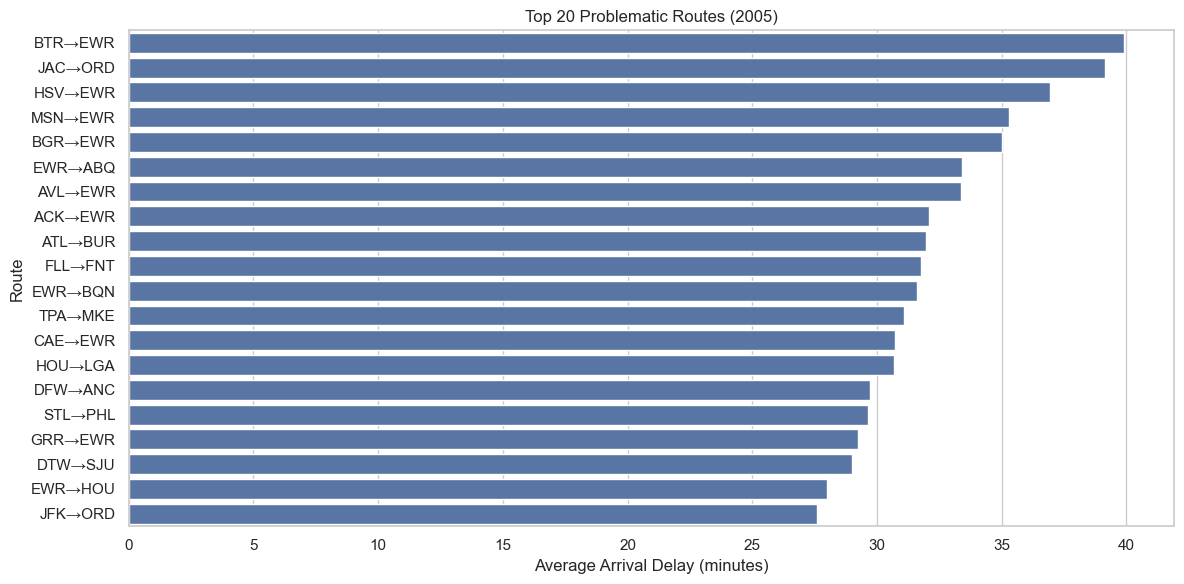

In [137]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_routes, x='avg_arr_delay', y=df_routes['origin'] + '→' + df_routes['dest'])
plt.title('Top 20 Problematic Routes (2005)')
plt.xlabel('Average Arrival Delay (minutes)')
plt.ylabel('Route')
plt.tight_layout()
plt.show()

Visualizing it, it is more obvious from the chart that the delay time of the top 20 is about 25 to 40 minutes, and the delay time from BTR to EWR is the longest. It can also be seen from the chart that EWR airport is the hardest hit area, appearing on at least ten problematic routes. Some routes have an average delay time of more than 35 minutes.

In [125]:
# Airline Analysis (carrier)
query_carriers = """
SELECT uniquecarrier AS carrier,
       COUNT(*) AS flight_count,
       AVG(CAST(arrdelay AS INT)) AS avg_arr_delay
FROM airline_cleaned_2005
GROUP BY uniquecarrier
ORDER BY avg_arr_delay DESC
"""

df_carriers = pd.read_sql(query_carriers, conn)
print(df_carriers)

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\2627933970.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_carriers = pd.read_sql(query_carriers, conn)


   carrier  flight_count  avg_arr_delay
0       FL        192468      14.366393
1       AS        155022      12.220440
2       B6        109753      10.804980
3       EV        290166       9.955839
4       XE        393277       8.892236
5       NW        472740       8.825350
6       CO        293194       8.572699
7       AA        662100       8.311734
8       DL        639289       7.913180
9       MQ        514335       7.657974
10      UA        478744       7.560358
11      US        416461       6.640204
12      DH        133486       6.010113
13      WN       1025637       5.335491
14      TZ         43586       4.632130
15      OO        506998       3.849619
16      F9         53014       3.507545
17      OH        369336       3.409673
18      HP        195120       3.346213
19      HA         48112      -2.305724


Using the clean data table that was previously cleaned, group by airline, and count the number of flights and average delay time of each airline. Sort the average delay time from high to low. From the results, we can see that the average arrival delay time of flights of FL, AS, and B6 in 2005 was more than 10 minutes, indicating that there was a significant punctuality problem. It is speculated that it may be related to operation density, weather influence, or airport traffic. HA is actually negative overall, indicating that it often arrives early or has no significant delays. Although WN has the largest number of flights, it still maintains a low delay, indicating that the scheduling management is very stable.

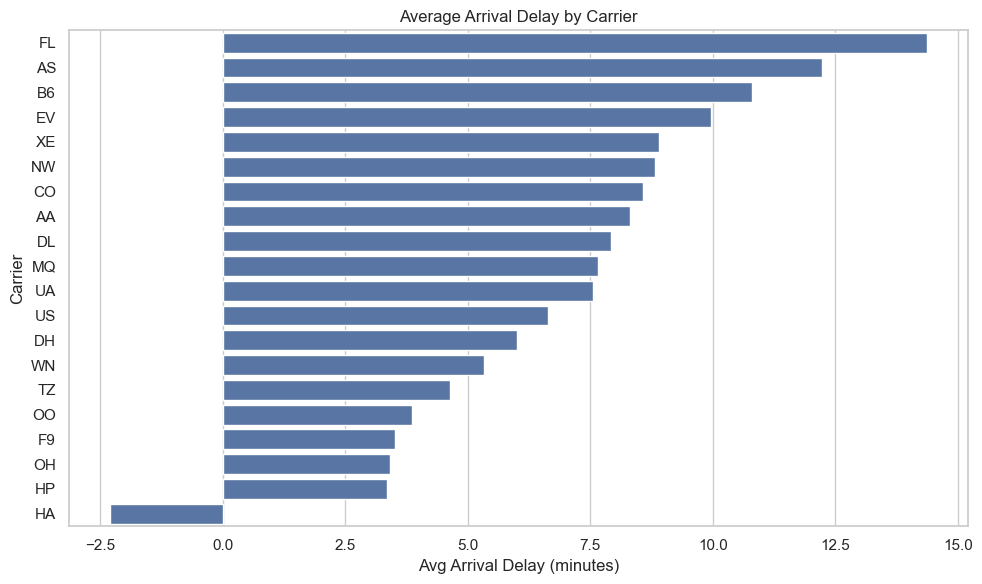

In [127]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_carriers, x='avg_arr_delay', y='carrier')
plt.title('Average Arrival Delay by Carrier')
plt.xlabel('Avg Arrival Delay (minutes)')
plt.ylabel('Carrier')
plt.tight_layout()
plt.show()

From the chart, we know that airlines are arranged in descending order of average delay time. FL, AS, and B6 airlines have the most serious arrival delays, with an average delay of more than 10 minutes per flight. Their service on-time rate needs to be improved. HA, HP, and OH performed best, among which Hawaiian Airlines is the only airline that arrives ahead of schedule on average, with significant operational efficiency and weather advantages.

In [150]:
# Analysis of Problem Flight Numbers
query_flightnums = """
SELECT flightnum,
       COUNT(*) AS flight_count,
       AVG(CAST(arrdelay AS INT)) AS avg_arr_delay
FROM airline_cleaned_2005
GROUP BY flightnum
HAVING flight_count > 50
ORDER BY avg_arr_delay DESC
LIMIT 20
"""

df_flightnums = pd.read_sql(query_flightnums, conn)
print(df_flightnums)

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\153800772.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_flightnums = pd.read_sql(query_flightnums, conn)


    flightnum  flight_count  avg_arr_delay
0        3275           257      51.124514
1        2692           380      46.105263
2        5442           434      44.894009
3        2669           327      43.449541
4        3209           379      42.482850
5        2882           321      39.246106
6        2383           442      38.006787
7        2854           223      37.681614
8        3065           225      37.191111
9        2943           295      36.006780
10       3053           288      35.958333
11       2782           453      35.543046
12       2740           208      35.504808
13       2567           145      35.013793
14       2864           273      34.457875
15       2393           914      34.266958
16       2994           223      34.206278
17       3127           121      32.619835
18       2292           644      32.198758
19       2996           320      31.646875


Using the cleaned data, group by flight number, and count the number of flights and average delay for each flight number. Filter out flight numbers with too small samples, and select the top 20 flight numbers with the highest average delay time. From the results, we can see that the average delay of flight numbers 3275, 2692, 5442, 2669, and 3209 is more than 40 minutes, which is very serious. If the airline retains fixed routes for these numbers, it means that there are structural problems with these routes/time periods. The average delay of almost all flights in these top 20 flights is more than 30 minutes. Numbers with a large number of flights, such as 2393: 914 times and 2292: 644 times, are also on the list, indicating that it is not accidental, but a long-term delay problem.

C:\Users\PC 22\AppData\Local\Temp\ipykernel_14608\1079752635.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_flightnums, x='flightnum', y='avg_arr_delay', palette=colors)


<function matplotlib.pyplot.show(close=None, block=None)>

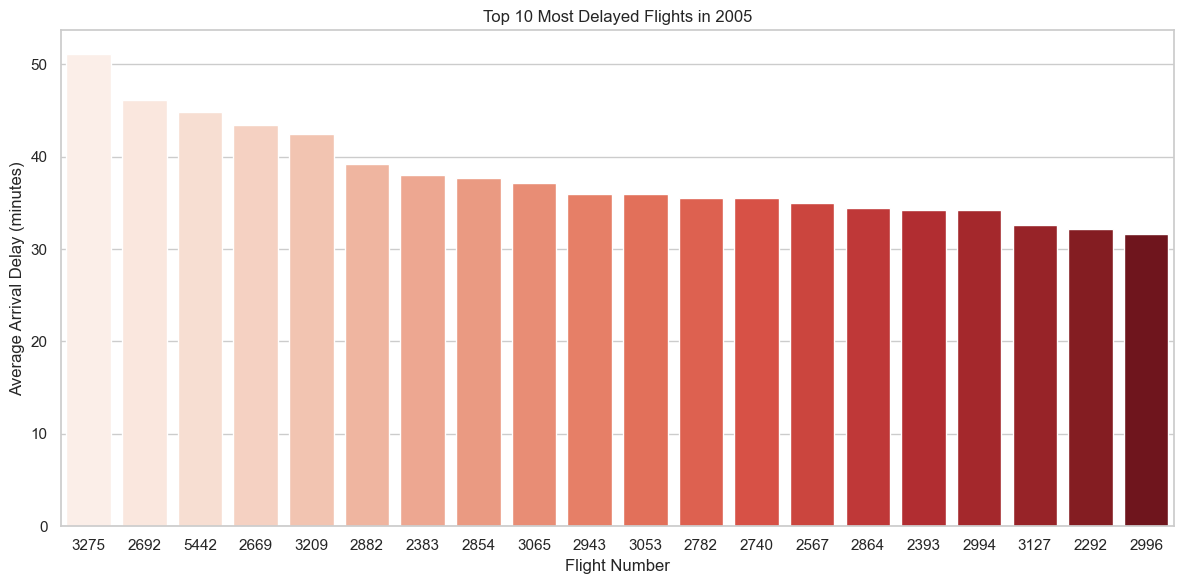

In [152]:
df_flightnums['flightnum'] = df_flightnums['flightnum'].astype(str)

plt.figure(figsize=(12, 6))
colors = sns.color_palette("Reds", len(df_flightnums))
sns.barplot(data=df_flightnums, x='flightnum', y='avg_arr_delay', palette=colors)

plt.title('Top 10 Most Delayed Flights in 2005')
plt.xlabel('Flight Number')
plt.ylabel('Average Arrival Delay (minutes)')
plt.tight_layout()
plt.show

As can be seen from the chart, from left to right, the color of the column gradually darkens, emphasizing that the delay time gradually decreases. The average delay time of the top 20 flights is more than 30 minutes, indicating that these flights are all severely delayed. 3275, 2692, 5442, 2669, 3209 These flights are regularly severely delayed, with an average delay of more than 40 minutes.

This section screened and analyzed routes with more than 50 flights in 2005, and identified the top 20 problem routes with the longest average arrival delays. The results show that some routes have significant delays, such as BTR → EWR, JAC → ORD, etc., with average delays of more than 35 minutes, and the most serious ones are as high as nearly 40 minutes. Most of these problem routes involve large hub airports (such as EWR, ORD), suggesting that they may be affected by flight traffic saturation, weather factors or poor connection scheduling. In addition, many problem routes point to Newark Airport (EWR), indicating that the airport may face greater flight access pressure or resource bottlenecks in 2005. In summary, problem routes have obvious spatial concentration and delay accumulation effects. It is recommended that relevant airlines or airports further analyze route resource allocation, timetable arrangements and regional weather risks to improve flight punctuality performance.

## 5. Conclusion

This time, the reasons for flight delays were systematically analyzed based on the flight operation data of the United States in 2005, from the dimensions of delay mode, delay causes, cancellation behavior, and identification of problem routes and airlines. The project used Hive for large-scale SQL queries, combined with PowerPoint Notebook, Pandas and visualization tools to complete data cleaning, processing and chart generation, and built a complete data analysis process.
The analysis found that flight delays have significant time patterns: the average delay time of early morning flights, summer months and Thursdays is generally higher, while flights in the morning, spring and autumn, and Saturdays are more punctual; cancellation behavior is concentrated in winter and the first quarter, showing a strong seasonal influence. At the same time, in the route analysis, many problem routes with an average arrival delay time of more than 30 minutes were identified, especially the route connecting EWR repeatedly appeared in the high delay list, suggesting that the airport may have traffic saturation or operation bottlenecks.
In addition, through comparative analysis of airlines, it was found that the flight delay levels of FL and AS were significantly higher than the industry average, while HA showed excellent punctuality. Overall, flight delays and cancellations show structural differences at the time, route, airline and airport levels. This analysis not only helps us understand the complexity of flight operations, but also verifies the practical application value of data analysis tools in air transport management and operational decision-making.

## 6. Shortcomings And Suggestions

This time, we completed the exploratory analysis of flight data in 2005, but there are still some aspects that can be improved, as follows:

- Limited data sources and time range

This analysis is based on data from 2005 only, lacks cross-year comparative analysis, and cannot evaluate the long-term trend of delays and cancellations. In the future, multi-year data can be introduced for time series analysis and trend modeling.

- Variable selection is slightly limited

The analysis mainly focuses on variables such as time, airport, airline, and route, and does not further introduce influencing factors such as weather, ticket prices, and passenger flow, resulting in limited explanatory power for the reasons for delays and cancellations. In the future, multi-source fusion analysis can be combined with weather data sets, FAA air traffic control notices, etc.

- The analysis method is descriptive

Currently, the analysis mainly uses group statistics and visualization, which is a descriptive analysis, and has not yet used advanced methods such as regression modeling, clustering, and prediction. If combined with algorithms such as logistic regression and XGBoost, the probability prediction and impact weight of flight cancellations can be further explored.

- The association between problematic routes and problematic airlines is not deep enough

The routes and flight numbers with serious delays were identified, but they were not further cross-analyzed with specific airlines and time periods. In the future, joint table queries and hierarchical aggregation can be added to find out the operating mode behind "high-risk flights".

- The visualization of the results is limited

Some charts are still single-dimensional static charts, lacking interactive components or dynamic charts. In the future, you can try to use Plotly, Dash or Streamlit to create interactive analysis panels to improve expression and user experience.

Overall, this assignment has met the basic requirements in data processing and pattern recognition, but there is still much room for improvement in data expansion, model application and deep interpretation. By introducing more dimensions, enriching analysis tools and enhancing interactive effects, it will help improve the integrity and practicality of flight operation data analysis.

Based on the results of this flight delay and cancellation analysis, substantive suggestions are made to Airlines and Customers respectively:

First, advice to airlines
- Optimize winter and early morning flight scheduling

The data shows that the cancellation rate and delay rate in winter and early morning are significantly higher. It is recommended that airlines:

Appropriately reduce the density of redundant flights;

Deploy alternative crews and reserve aircraft in advance;

Improve the fault tolerance and recovery capability of ground operations during these high-risk periods.

- Focus on high-delay airports and route resource allocation

For high-delay airports such as EWR, it is recommended that airlines:

Optimize take-off and landing time applications;

Increase the reserved time for connecting flights;

Avoid using connecting flights on high-delay routes to reduce passenger complaints.

- Establish a route risk scoring system

According to the flight delay and cancellation rate, risk level labels are set up for each route to assist route planning, revenue management and customer service early warning systems.

- Strengthen information linkage with air traffic control/meteorological agencies

In the high cancellation rate season, airlines should establish a real-time linkage mechanism with air traffic control and meteorological bureaus to improve the early warning response speed and avoid long waiting and resource waste.

- Improve the operational quality of problematic flight numbers

For problematic flight numbers with delays of more than 30 minutes, it is recommended to find the underlying causes and optimize them from aspects such as scheduling, backup, and schedule design.

Another suggestion for customers
- Try to choose morning flights

Data shows that morning flights have the least average delays, while evening and early morning flights are most susceptible to delays. Passengers are advised to give priority to morning flights to improve punctuality.

- Avoid traveling during winter and summer peak periods

The cancellation rate in winter (especially in the first quarter) is significantly higher, and the delay time in summer (July-August) is longer. Passengers are advised to avoid high-risk months within a controllable range.

- Pay attention to differences in airline service levels

Some airlines (such as FL and AS) have a high delay rate. Passengers can refer to the delay data to choose more stable airlines, such as HA and WN.

- Carefully choose transfer and connecting flights

If you must transfer, it is recommended to choose a transfer plan with a longer connection time and a non-high-delay airport to reduce the risk of missing the flight due to delays.

- Take advantage of airline delay protection services and insurance products

Faced with the risk of systemic delays, passengers can pay attention to whether the airline provides protection services (such as rebooking, hotel compensation, etc.) or purchase related insurance products to improve travel protection.